In [1]:
import os, sys, platform, yaml, re
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType, FloatType, StringType
from pathlib import Path
import matplotlib.pyplot as plt

# Preparación

In [2]:
conf_path = str(Path.cwd() / "config" / "ETL_config.yaml")
with open(conf_path, "r") as f:
    CFG = yaml.safe_load(f)

IS_WIN          = platform.system() == "Windows"
CSV_DIR         = CFG["paths"]["csv_base_dir"]["windows" if IS_WIN else "linux"]
PG_URL          = CFG["postgres"]["url"]
PG_USER         = CFG["postgres"]["user"]
PG_PASS         = CFG["postgres"]["pass"]
PG_SCHEMA       = CFG["postgres"]["schema_out"]["schema_name"]
PG_TABLE1       = CFG["postgres"]["schema_out"]["table1"]
PG_TABLE2       = CFG["postgres"]["schema_out"]["table2"]
PG_TABLE3       = CFG["postgres"]["schema_out"]["table3"]
FILES           = CFG["csv"]["files"]
NUM_PARTITIONS  = CFG["csv"]["num_partitions"]
JDBC_BATCHSIZE  = CFG["postgres"]["batchsize"]
JDBC_FETCHSIZE  = CFG["postgres"]["fetchsize"]
SPARK_LOCAL_DIR = CFG["spark"]["local_dirs"]["windows" if IS_WIN else "linux"]
NEO4J_URI  = CFG["neo4j"]["uri"]          # "bolt://localhost:7687"
NEO4J_USER = CFG["neo4j"]["user"]
NEO4J_PASS = CFG["neo4j"]["pass"]
NEO4J_DB   = CFG["neo4j"]["database"]

opts = {
    "url": NEO4J_URI,
    "authentication.type": "basic",
    "authentication.basic.username": NEO4J_USER,
    "authentication.basic.password": NEO4J_PASS,
    "database": NEO4J_DB,
}

os.environ["PYSPARK_PYTHON"] = sys.executable       # usa el Python del kernel actual
os.environ["JAVA_HOME"] = os.environ.get("JAVA_HOME", "/usr/lib/jvm/java-17-openjdk-amd64") #Chequear versión Windows después
Path(SPARK_LOCAL_DIR).mkdir(parents=True, exist_ok=True)


In [3]:
builder = (
    SparkSession.builder
    .master("local[*]")  
    .appName(CFG["spark"]["app_name"])
    .config("spark.sql.shuffle.partitions", str(CFG["spark"]["shuffle_partitions"]))
    .config("spark.driver.memory", CFG["spark"]["driver_memory"])
    .config("spark.driver.bindAddress", "127.0.0.1")
    .config("spark.driver.host", "127.0.0.1")
    .config("spark.local.dir", SPARK_LOCAL_DIR)   
    #.config("spark.jars.packages", ",".join(CFG["spark"]["local_jars"]["linux"]))
    .config(
        "spark.jars.packages",
        ",".join([
            "org.postgresql:postgresql:42.7.4",
            "org.neo4j:neo4j-connector-apache-spark_2.12:5.3.10_for_spark_3"
        ])
    )
)

spark = builder.getOrCreate()
spark.sparkContext.setLogLevel("WARN")

jdbc_props = {
        "user": PG_USER,
        "password": PG_PASS,
        "driver": "org.postgresql.Driver",
        "fetchsize": str(JDBC_FETCHSIZE)
    }


25/11/10 09:36:29 WARN Utils: Your hostname, AsusMare resolves to a loopback address: 127.0.1.1; using 192.168.100.4 instead (on interface wlp2s0)
25/11/10 09:36:29 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/opt/spark-3.5.3-bin-hadoop3/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/felpipe/.ivy2/cache
The jars for the packages stored in: /home/felpipe/.ivy2/jars
org.postgresql#postgresql added as a dependency
org.neo4j#neo4j-connector-apache-spark_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-26fb6932-24a8-4450-b1bf-93c0a96066c0;1.0
	confs: [default]
	found org.postgresql#postgresql;42.7.4 in central
	found org.checkerframework#checker-qual;3.42.0 in central
	found org.neo4j#neo4j-connector-apache-spark_2.12;5.3.10_for_spark_3 in central
	found org.neo4j#neo4j-connector-apache-spark_2.12_common;5.3.10_for_spark_3 in central
	found org.neo4j#caniuse-core;1.3.0 in local-m2-cache
	found org.neo4j#caniuse-api;1.3.0 in local-m2-cache
	found org.jetbrains.kotlin#kotlin-stdlib;2.1.20 in local-m2-cache
	found org.jetbrains#annotations;13.0 in local-m2-cache
	found org.neo4j#caniuse-neo4j-detection;1.3.0 in local-m2-cache
	found org.neo4j.driver#neo4j-java-driver-slim;4.4.21 in local-m2-cache
	

In [4]:
df_acc = (spark.read.format("jdbc")
        .option("url", PG_URL)
        .option("dbtable", f"{PG_SCHEMA}.{PG_TABLE1}")
        .option("partitionColumn", "account")
        .option("lowerBound", 1)                  
        .option("upperBound", 2000000)
        .option("numPartitions", 16)               
        .options(**jdbc_props)
        .load())

df_txs = (spark.read.format("jdbc")
        .option("url", PG_URL)
        .option("dbtable", f"{PG_SCHEMA}.{PG_TABLE2}")
        .option("partitionColumn", "id")
        .option("lowerBound", 1)
        .option("upperBound", 9500000)
        .option("numPartitions", 64)
        .options(**jdbc_props)
        .load())

acc_bounds = df_acc.select(
        F.min("account").cast("long").alias("lo"),
        F.max("account").cast("long").alias("hi")
    ).first()
acc_lo, acc_hi = int(acc_bounds["lo"]), int(acc_bounds["hi"])

df_sta =  (spark.read.format("jdbc")
        .option("url", PG_URL)
        .option("dbtable", f"{PG_SCHEMA}.{PG_TABLE3}")
        .option("partitionColumn", "account")       # particionamos por cuenta
        .option("lowerBound", acc_lo)
        .option("upperBound", acc_hi)
        .option("numPartitions", 64)                 # ajústalo a tu máquina/cluster
        .options(**jdbc_props)
        .load()
        .select(
            F.col("account").cast("long").alias("account"),
            F.col("date_time").alias("date_time"),
            F.col("txn_id").cast("long").alias("txn_id"),
            F.col("direction").alias("direction"),
            F.col("delta_amount").cast("double").alias("delta_amount"),
            F.col("running_balance").cast("double").alias("running_balance")
        )
    )

# Análisis univariado

## Setup inicial y overview

In [5]:
# Verificar conteos básicos
print("Accounts:", df_acc.count())
print("Transactions:", df_txs.count())
print("Statements:", df_sta.count())

# Visualizar schemas y sample
df_acc.printSchema()
df_txs.printSchema()
df_sta.printSchema()

df_acc.show(5)
df_txs.show(5)
df_sta.show(5)

Accounts: 855460


Transactions: 9504852


Statements: 19009704
root
 |-- account: long (nullable = true)
 |-- location: string (nullable = true)

root
 |-- id: long (nullable = true)
 |-- date_time: timestamp (nullable = true)
 |-- sender_account: long (nullable = true)
 |-- receiver_account: long (nullable = true)
 |-- amount: double (nullable = true)
 |-- payment_currency: string (nullable = true)
 |-- received_currency: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- is_laundering: integer (nullable = true)
 |-- laundering_type: string (nullable = true)

root
 |-- account: long (nullable = true)
 |-- date_time: timestamp (nullable = true)
 |-- txn_id: long (nullable = true)
 |-- direction: string (nullable = true)
 |-- delta_amount: double (nullable = true)
 |-- running_balance: double (nullable = true)

+-------+--------+
|account|location|
+-------+--------+
|  99278|      UK|
| 114277|      UK|
|  28511|      UK|
|  23159|      UK|
|  58673|      UK|
+-------+--------+
only showing top 5 rows

+

## Chequeo de missing values y duplicados

In [6]:
def null_summary(df, name: str, include_empty_strings: bool = True, show_pct: bool = True):
    # Identifica tipos por columna
    numeric_nan_cols = {
        f.name for f in df.schema.fields
        if isinstance(f.dataType, (DoubleType, FloatType))
    }
    string_cols = {
        f.name for f in df.schema.fields
        if isinstance(f.dataType, StringType)
    }

    # Construye expresiones por columna
    exprs = []
    for c in df.columns:
        cond = F.col(c).isNull()
        if c in numeric_nan_cols:
            cond = cond | F.isnan(c)
        if include_empty_strings and c in string_cols:
            cond = cond | (F.trim(F.col(c)) == "")
        exprs.append(F.sum(F.when(cond, 1).otherwise(0)).alias(c))

    # Ejecuta el cómputo
    counts = df.select(exprs).first().asDict()
    total = df.count()

    print(f"Resumen de valores nulos en '{name}':")
    for c in df.columns:
        n = int(counts[c])
        if show_pct and total > 0:
            pct = 100.0 * n / total
            print(f'  - "{c}": {n:,} ({pct:.2f}%)')
        else:
            print(f'  - "{c}": {n:,}')
    

null_summary(df_acc, "accounts")
null_summary(df_txs, "transactions")
null_summary(df_sta, "statements")

Resumen de valores nulos en 'accounts':
  - "account": 0 (0.00%)
  - "location": 0 (0.00%)


Resumen de valores nulos en 'transactions':
  - "id": 0 (0.00%)
  - "date_time": 0 (0.00%)
  - "sender_account": 0 (0.00%)
  - "receiver_account": 0 (0.00%)
  - "amount": 0 (0.00%)
  - "payment_currency": 0 (0.00%)
  - "received_currency": 0 (0.00%)
  - "payment_type": 0 (0.00%)
  - "is_laundering": 0 (0.00%)
  - "laundering_type": 0 (0.00%)


[Stage 30:=================================================>      (57 + 7) / 64]

Resumen de valores nulos en 'statements':
  - "account": 0 (0.00%)
  - "date_time": 0 (0.00%)
  - "txn_id": 0 (0.00%)
  - "direction": 0 (0.00%)
  - "delta_amount": 0 (0.00%)
  - "running_balance": 0 (0.00%)


In [7]:
# Duplicados
print("Duplicados accounts:", df_acc.count() - df_acc.dropDuplicates().count())
print("Duplicados transactions:", df_txs.count() - df_txs.dropDuplicates().count())
print("Duplicados statements:", df_sta.count() - df_sta.dropDuplicates().count())

Duplicados accounts: 0


Duplicados transactions: 0


[Stage 56:==============================================>          (9 + 2) / 11]

Duplicados statements: 0


## Verificación de claves y consistencia básica

In [8]:
# Verificar que todas las cuentas usadas en transacciones existen en df_acc
unique_tx_accounts = (
    df_txs
    .select(F.col("sender_account").alias("account"))
    .union(df_txs.select(F.col("receiver_account").alias("account")))
    .distinct()
)

missing_accounts = unique_tx_accounts.join(df_acc, "account", "left_anti")
print("Cuentas en transacciones no presentes en accounts:", missing_accounts.count())


[Stage 64:============>                                             (2 + 7) / 9]

Cuentas en transacciones no presentes en accounts: 0


## Tipificación y valores anómalos

In [9]:
print(f'Montos negativos o cero (si no debieran existir): {df_txs.filter(F.col("amount") <= 0).count()}')

print('Fechas fuera de rango')
df_txs.agg(
    F.min("date_time").alias("min_date"),
    F.max("date_time").alias("max_date")
).show()

print(f'Verificar transacciones con misma cuenta de origen y destino: {df_txs.filter(F.col("sender_account") == F.col("receiver_account")).count()}')


Montos negativos o cero (si no debieran existir): 0
Fechas fuera de rango


+-------------------+-------------------+
|           min_date|           max_date|
+-------------------+-------------------+
|2022-10-07 10:35:19|2023-08-23 10:57:12|
+-------------------+-------------------+



[Stage 75:===================================================>    (59 + 5) / 64]

Verificar transacciones con misma cuenta de origen y destino: 0


## Análisis univariado: Accounts

La clave única para la columna accounts es account, por lo tanto en efecto deberían haber tantas cuentas como filas.

In [19]:
print(f'Cantidad distinta de cuentas en el set de datos: {df_acc.select(F.col("account")).distinct().count():,}'.replace(',','.'))

[Stage 90:====================================================>   (15 + 1) / 16]

Cantidad distinta de cuentas en el set de datos: 855.460


In [21]:
df_acc \
    .select(F.col('location')) \
    .groupby(F.col('location')) \
    .count().show()

+-----------+------+
|   location| count|
+-----------+------+
|         UK|803407|
|    Austria|  3072|
|      India|  3057|
|    Germany|  3051|
|   Pakistan|  3100|
|      Spain|  3066|
|Netherlands|  3006|
|     Mexico|  3149|
|     Turkey|  3072|
|Switzerland|  3053|
|        USA|  3056|
|    Morocco|  3031|
|      Japan|  3095|
|    Nigeria|  3111|
|        UAE|  3042|
|    Albania|  3086|
|      Italy|  2968|
|     France|  3038|
+-----------+------+



In [22]:
print(f'El set contiene {df_acc.select(F.col("location")).distinct().count()} localidades diferentes')

El set contiene 18 localidades diferentes


Conviene, más tarde, codificar estas localidades con hash de 5 bits. La distribución de probabilidades es bastante uniforme en el set completo, excepto para UK con la que tiene un sesgo enorme. Esta columna se pone a riesgo de ser poco informativa, por lo que el set se vuelve candidato de aumento de datos solo por esta columna. La alternativa es eliminarla.

## Análisis univariado: Transferencias

De manera similar, hacemos las cuentas con el id de la transacción.

In [26]:
print(f'Cantidad distinta de cuentas en el set de datos: {df_txs.select(F.col("id")).distinct().count():,}'.replace(',','.'))

[Stage 107:===================>                                     (3 + 6) / 9]

Cantidad distinta de cuentas en el set de datos: 9.504.852


In [31]:
print('Fechas mínima y máximas del dataset')
df_txs.agg(
    F.min("date_time").alias("min_date"),
    F.max("date_time").alias("max_date")
).show()

df_txs.agg(
        (F.datediff(F.max("date_time"), F.min("date_time"))).alias("dias_entre_fechas")
    ).show()

Fechas mínima y máximas del dataset


+-------------------+-------------------+
|           min_date|           max_date|
+-------------------+-------------------+
|2022-10-07 10:35:19|2023-08-23 10:57:12|
+-------------------+-------------------+



[Stage 129:=====================================================> (62 + 2) / 64]

+-----------------+
|dias_entre_fechas|
+-----------------+
|              320|
+-----------------+



In [37]:
print(f"Número de cuentas diferentes que envían: {df_txs.select(F.col('sender_account')).distinct().count()}")

[Stage 150:==================================================>    (59 + 5) / 64]

Número de cuentas diferentes que envían: 292715


In [38]:
print(f"Número de cuentas diferentes que envían: {df_txs.select(F.col('receiver_account')).distinct().count()}")

[Stage 156:===================================================>   (60 + 4) / 64]

Número de cuentas diferentes que envían: 652266


Existe un fuerte desbalance entre la cantidad de cuentas que envían vs las que reciben ~2:1. Chequear el número de hubs y la cantidad de éstos en el dataset en comparación con el resto de nodos. Revisar el EDA grafo para este detalle.

In [39]:
df_txs.agg(
    F.min("amount").alias("min_amount"),
    F.max("amount").alias("max_amount")
).show()

[Stage 162:====================================================>  (61 + 3) / 64]

+----------+------------+
|min_amount|  max_amount|
+----------+------------+
|      3.73|1.26184984E7|
+----------+------------+



In [41]:
quantiles = [0.01, 0.25, 0.5, 0.75, 0.99]

# Cuantiles usando los valores originales de 'amount'
amount_quantiles = df_txs.approxQuantile("amount", quantiles, 0.01)

# Cuantiles usando logaritmo natural de 'amount'
df_log = df_txs.select(F.log10(F.col('amount')).alias('log_amount'))
log_quantiles = df_log.approxQuantile("log_amount", quantiles, 0.01)

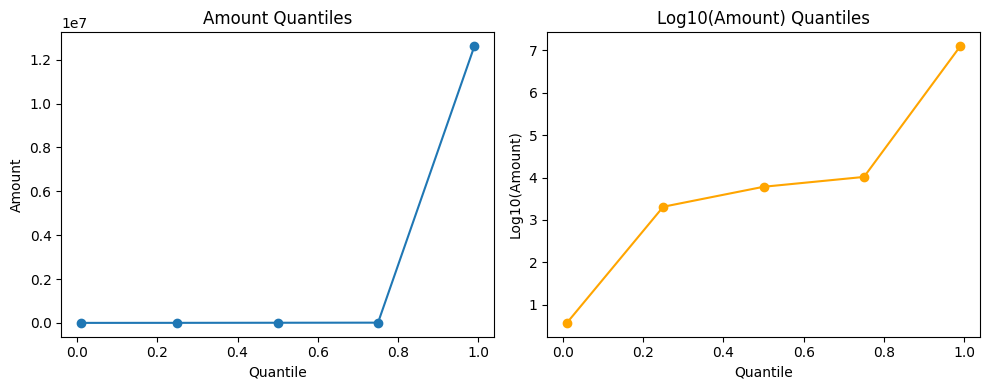

In [43]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(10, 4)
)

# Plot quantiles of 'amount'
axes[0].plot(
    quantiles,
    amount_quantiles,
    marker='o'
)
axes[0].set_title('Amount Quantiles')
axes[0].set_xlabel('Quantile')
axes[0].set_ylabel('Amount')

# Plot quantiles of log10('amount')
axes[1].plot(
    quantiles,
    log_quantiles,
    marker='o',
    color='orange'
)
axes[1].set_title('Log10(Amount) Quantiles')
axes[1].set_xlabel('Quantile')
axes[1].set_ylabel('Log10(Amount)')

plt.tight_layout()
plt.show()

Existe una marcada diferencia exponencial con respecto a cada cuantil. El gráfico en unidades absolutas es inútil a la hora de hacer seguimiento. Como la diferencia se presenta más o menos lineal en los cuantiles se concluye que conviene mantener esta transformación para trabajar con esta variable.

In [24]:
df_txs.columns

['id',
 'date_time',
 'sender_account',
 'receiver_account',
 'amount',
 'payment_currency',
 'received_currency',
 'payment_type',
 'is_laundering',
 'laundering_type']

# Otros

In [6]:

df_nodes = (
    spark.read.format("org.neo4j.spark.DataSource")
    .options(**opts)
    .option("query", "MATCH (n) LIMIT 5 RETURN id(n) AS id, labels(n) AS labels")
    .load()
)
df_nodes.show(truncate=False)


+---+---------+
|id |labels   |
+---+---------+
|0  |[Account]|
|1  |[Account]|
|2  |[Account]|
|3  |[Account]|
|4  |[Account]|
+---+---------+



In [8]:
df_nodes = (
    spark.read.format("org.neo4j.spark.DataSource")
    .options(**opts)
    .option("query", "MATCH (n) -[r:TX]-> (m) LIMIT 1 RETURN n, r, m")
    .load()
)
df_nodes.show(truncate=False)

+----------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|n                                                                                             |r                                                                                                                                 